In [ ]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [10]:
casing = pd.read_csv('../data/gasPump/casing.csv', names=["timestamp","pressure"]) 
print(len(casing))


casing.head()

353


,timestamp,pressure
0,8/21/2016 10:00,168.800003
1,8/21/2016 13:00,169.899994
2,8/21/2016 16:00,171.100006
3,8/21/2016 19:00,169.399994
4,8/21/2016 22:00,168.800003


In [11]:
casing.tail()

,timestamp,pressure
348,10/2/2016 6:00,166.500000
349,10/2/2016 9:00,149.899994
350,10/2/2016 11:00,159.600006
351,10/2/2016 14:00,145.300003
352,10/2/2016 15:00,169.399994


<AxesSubplot:xlabel='timestamp'>

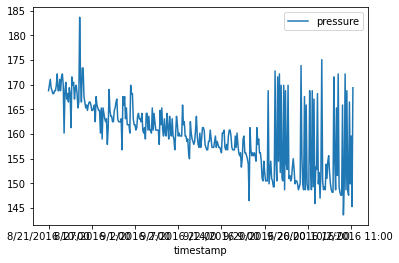

In [9]:
casing.set_index('timestamp').plot()

In [12]:
# alright we have 353 rows of data over the course of months. 
# seems like the timestamps arent uniform distance from each other 
# which is interesting. shouldnt matter for us I believe.

# first dropping timestamp col
casing = casing.drop(columns=["timestamp"]).to_numpy()

casing.shape

(353, 1)

In [40]:
# lets make some windows 
# we really don't have a lot of training data 
# so these overlaps will be pretty small. 
# thinking of length 100 - checking with audrey now.

window_shape = (100, 1)
windowed_data = view_as_windows(casing, window_shape, step=5)
windowed_data = np.squeeze(windowed_data)
windowed_data.shape

(51, 100)

In [41]:
windowed_data = windowed_data[:, :, np.newaxis]
windowed_data.shape

(51, 100, 1)

In [42]:
def plot_100_slice(slice, ind):
    plt.plot(slice, label="pressure")
    ax = plt.gca()
    ax.title.set_text("Slice" +str(ind))
    plt.legend(prop={'size': 9})

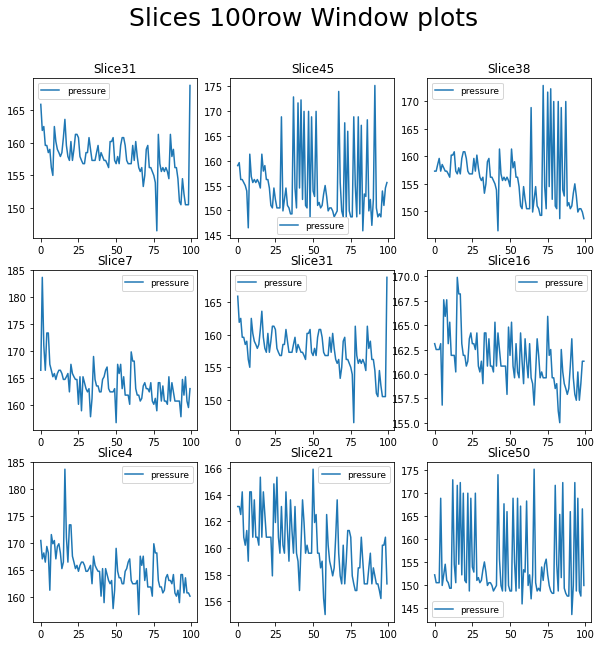

In [43]:

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Slices 100row Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(51)
    sl = windowed_data[index]
    plot_100_slice(sl, index)
    
plt.show()

In [44]:
# Recommended to train with a GPU 
torch.cuda.is_available()

False

In [45]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=windowed_data.shape[1],
    sample_len=20, # trying a larger sample_len
    batch_size=min(1000, windowed_data.shape[0]),
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

In [ ]:
start = time.time()
model.train_numpy(
    windowed_data,
    feature_types=[OutputType.CONTINUOUS] * windowed_data.shape[2],
)
stop = time.time()
print(f"Training time: {stop - start}s")

### cleared output of that cell - prints per epoch so 10,000 times

In [48]:
print(f"Training time: {stop - start}s")

Training time: 257.60725378990173s


In [49]:
# saving model for future use 
model.save("dgan_casing.pt")

In [50]:
# Generate synthetic data - this ran near instantly
_, synthetic_features = model.generate_numpy(1000)

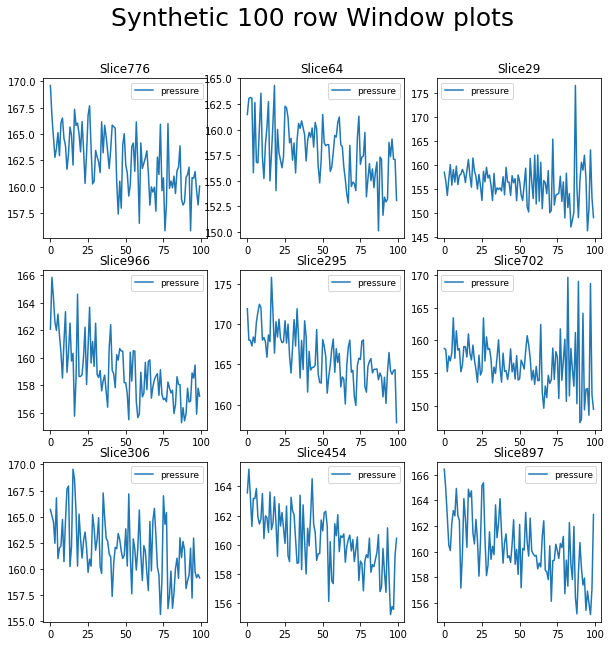

In [52]:
# plot random synthetic windows

figure = plt.figure(figsize=(10, 10))
figure.suptitle("Synthetic 100 row Window plots", fontsize=25, fontweight='roman')

for i in range(9):
    figure.add_subplot(3, 3, i+1)
    index = np.random.choice(1000)
    sl = synthetic_features[index]
    plot_100_slice(sl, index)
    
plt.show()

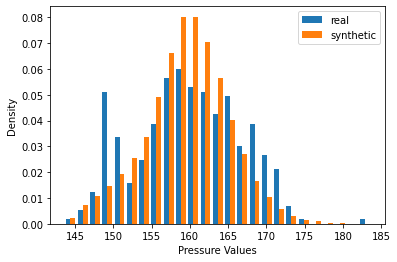

In [60]:
# Compare distribution of pressure values
plt.hist([casing.flatten(), synthetic_features[:,:,0].flatten()], 
         label=["real", "synthetic"],
         bins=25,
         density=True)
plt.legend()
plt.xlabel("Pressure Values")
plt.ylabel("Density")
plt.show()